In [1]:
import pymssql, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

In [2]:
DB_CONFIG = {
    'server': os.getenv('DB_SERVER', 'localhost'),
    'port': os.getenv('DB_PORT', '1433'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME', 'ClimateDB')
}

In [3]:
def get_connection():
    """Obtiene una conexión a la base de datos."""
    return pymssql.connect(**DB_CONFIG)

# **Check connection**

In [4]:
try:
    conn = get_connection()
    cursor = conn.cursor()
    cursor.execute("SELECT DB_NAME()")
    db_name = cursor.fetchone()[0]
    print(f"✅ Conectado a: {db_name}")
    print(f"   Server: {DB_CONFIG['server']}:{DB_CONFIG['port']}")
    conn.close()
except Exception as e:
    print(f"❌ Error de conexión: {e}")

✅ Conectado a: ClimateDB
   Server: localhost:1433


In [5]:
conn = get_connection()
cursor = conn.cursor()

cursor.execute("""
    SELECT TABLE_NAME 
    FROM INFORMATION_SCHEMA.TABLES 
    WHERE TABLE_TYPE = 'BASE TABLE'
""")

print("📊 Tablas en ClimateDB:")
for row in cursor.fetchall():
    print(f"   • {row[0]}")

conn.close()

📊 Tablas en ClimateDB:
   • climate_observations


In [6]:
conn = get_connection()
cursor = conn.cursor()

tables = ['climate_observations', 'climate_predictions', 'model_registry', 'ingestion_logs']

print("📈 Conteo de registros:\n")
for table in tables:
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {table}")
        count = cursor.fetchone()[0]
        print(f"   {table}: {count:,} registros")
    except:
        print(f"   {table}: ❌ No existe")

conn.close()

📈 Conteo de registros:

   climate_observations: 1,139,112 registros
   climate_predictions: ❌ No existe
   model_registry: ❌ No existe
   ingestion_logs: ❌ No existe


In [7]:
conn = get_connection()

query = """
    SELECT 
        municipio,
        COUNT(*) as registros,
        MIN(datetime) as fecha_inicio,
        MAX(datetime) as fecha_fin,
        AVG(wind_speed_10m) as avg_wind_speed,
        AVG(temperature_2m) as avg_temperature
    FROM climate_observations
    GROUP BY municipio
    ORDER BY municipio
"""

df_stats = pd.read_sql(query, conn)
conn.close()

print("📊 Resumen de datos por municipio:\n")
display(df_stats)

📊 Resumen de datos por municipio:



,municipio,registros,fecha_inicio,fecha_fin,avg_wind_speed,avg_temperature
0,albania,87624,2015-12-21,2025-12-18 23:00:00,9.339294,27.289533
1,barrancas,87624,2015-12-21,2025-12-18 23:00:00,11.830405,27.870796
2,distraccion,87624,2015-12-21,2025-12-18 23:00:00,13.237239,27.878198
3,el_molino,87624,2015-12-21,2025-12-18 23:00:00,12.437099,27.690288
4,fonseca,87624,2015-12-21,2025-12-18 23:00:00,12.658548,28.009259
5,hatonuevo,87624,2015-12-21,2025-12-18 23:00:00,9.336363,26.887922
6,la_jagua_del_pilar,87624,2015-12-21,2025-12-18 23:00:00,14.688101,28.374023
7,maicao,87624,2015-12-21,2025-12-18 23:00:00,15.349213,27.639091
8,manaure,87624,2015-12-21,2025-12-18 23:00:00,17.624694,28.551882
9,mingueo,87624,2015-12-21,2025-12-18 23:00:00,8.296277,26.424275


In [8]:
conn = get_connection()

query = """
    SELECT TOP 10 
        municipio, datetime, wind_speed_10m, 
        temperature_2m, precipitation
    FROM climate_observations
    ORDER BY datetime DESC
"""

df_recent = pd.read_sql(query, conn)
conn.close()

print("🕐 Últimos 10 registros:\n")
display(df_recent)

🕐 Últimos 10 registros:



,municipio,datetime,wind_speed_10m,temperature_2m,precipitation
0,distraccion,2025-12-18 23:00:00,7.3,24.0,0.0
1,fonseca,2025-12-18 23:00:00,7.3,24.1,0.0
2,albania,2025-12-18 23:00:00,6.6,22.9,0.0
3,barrancas,2025-12-18 23:00:00,5.1,21.8,0.0
4,maicao,2025-12-18 23:00:00,6.4,24.4,0.0
5,la_jagua_del_pilar,2025-12-18 23:00:00,11.4,26.3,0.0
6,mingueo,2025-12-18 23:00:00,5.0,25.8,0.0
7,riohacha,2025-12-18 23:00:00,12.8,26.6,0.0
8,uribia,2025-12-18 23:00:00,9.4,26.7,0.0
9,manaure,2025-12-18 23:00:00,13.4,27.4,0.0


In [9]:
conn = get_connection()

# Verificar valores nulos
query_nulls = """
    SELECT 
        SUM(CASE WHEN wind_speed_10m IS NULL THEN 1 ELSE 0 END) as null_wind,
        SUM(CASE WHEN temperature_2m IS NULL THEN 1 ELSE 0 END) as null_temp,
        SUM(CASE WHEN precipitation IS NULL THEN 1 ELSE 0 END) as null_precip,
        COUNT(*) as total
    FROM climate_observations
"""

df_nulls = pd.read_sql(query_nulls, conn)
conn.close()

print("🔍 Verificación de valores nulos:\n")
print(f"   Wind Speed NULL: {df_nulls['null_wind'].iloc[0]:,}")
print(f"   Temperature NULL: {df_nulls['null_temp'].iloc[0]:,}")
print(f"   Precipitation NULL: {df_nulls['null_precip'].iloc[0]:,}")
print(f"   Total registros: {df_nulls['total'].iloc[0]:,}")

🔍 Verificación de valores nulos:

   Wind Speed NULL: 0
   Temperature NULL: 0
   Precipitation NULL: 0
   Total registros: 1,139,112


In [10]:
conn = get_connection()

query = """
    SELECT 
        MIN(wind_speed_10m) as min_wind,
        MAX(wind_speed_10m) as max_wind,
        AVG(wind_speed_10m) as avg_wind,
        MIN(temperature_2m) as min_temp,
        MAX(temperature_2m) as max_temp,
        AVG(temperature_2m) as avg_temp
    FROM climate_observations
"""

df_desc = pd.read_sql(query, conn)
conn.close()

print("📈 Estadísticas descriptivas:\n")
print(f"   🌬️ Wind Speed: min={df_desc['min_wind'].iloc[0]:.1f}, max={df_desc['max_wind'].iloc[0]:.1f}, avg={df_desc['avg_wind'].iloc[0]:.1f}")
print(f"   🌡️ Temperature: min={df_desc['min_temp'].iloc[0]:.1f}, max={df_desc['max_temp'].iloc[0]:.1f}, avg={df_desc['avg_temp'].iloc[0]:.1f}")

📈 Estadísticas descriptivas:

   🌬️ Wind Speed: min=0.0, max=45.4, avg=13.1
   🌡️ Temperature: min=18.2, max=40.5, avg=27.8


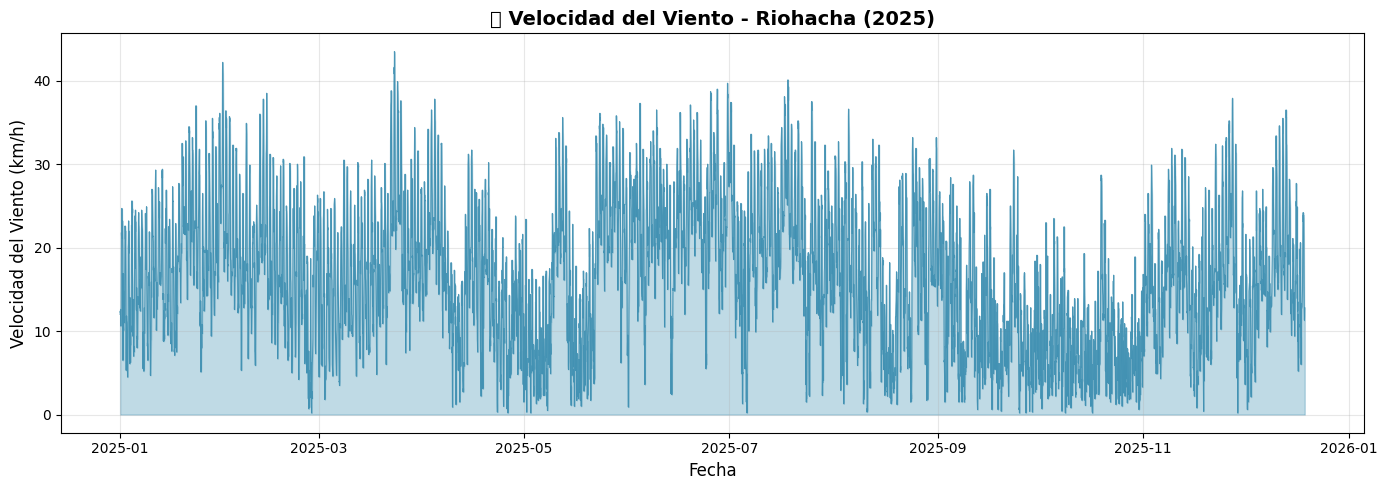

In [11]:
# Obtener datos de un municipio
conn = get_connection()

query = """
    SELECT datetime, wind_speed_10m, temperature_2m
    FROM climate_observations
    WHERE municipio = 'riohacha'
    AND datetime >= '2025-01-01'
    ORDER BY datetime
"""

df = pd.read_sql(query, conn)
df['datetime'] = pd.to_datetime(df['datetime'])
conn.close()

# Crear gráfica
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df['datetime'], df['wind_speed_10m'], color='#2E86AB', linewidth=0.8, alpha=0.8)
ax.fill_between(df['datetime'], df['wind_speed_10m'], alpha=0.3, color='#2E86AB')

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Velocidad del Viento (km/h)', fontsize=12)
ax.set_title('🌬️ Velocidad del Viento - Riohacha (2025)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

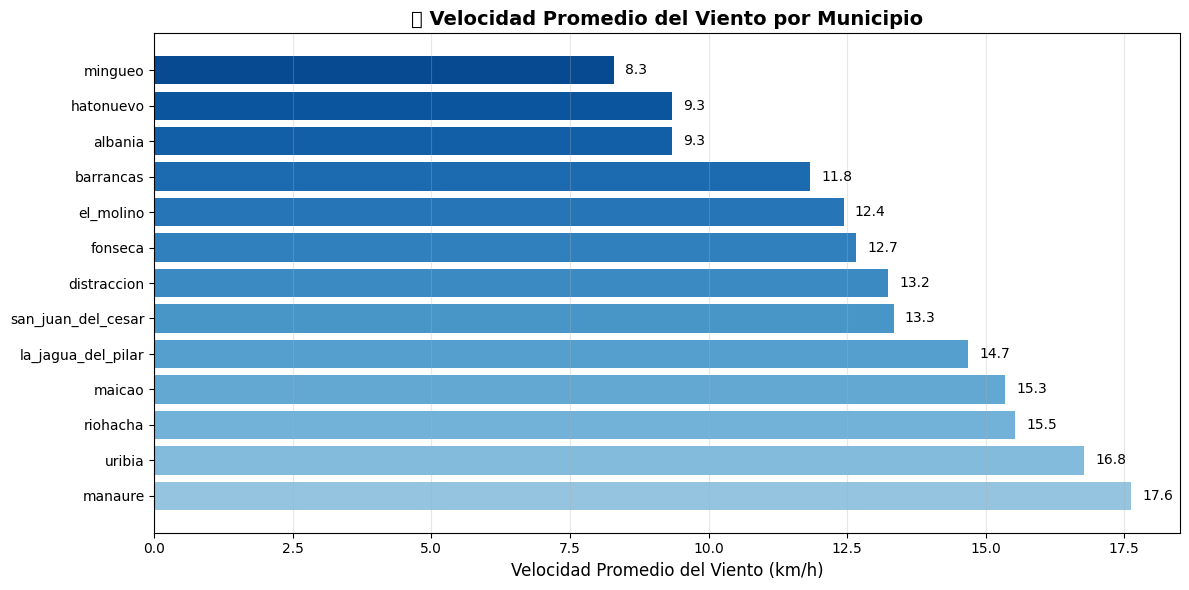

In [12]:
conn = get_connection()

query = """
    SELECT municipio, AVG(wind_speed_10m) as avg_wind
    FROM climate_observations
    GROUP BY municipio
    ORDER BY avg_wind DESC
"""

df_avg = pd.read_sql(query, conn)
conn.close()

# Gráfica de barras
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(df_avg)))
bars = ax.barh(df_avg['municipio'], df_avg['avg_wind'], color=colors)

ax.set_xlabel('Velocidad Promedio del Viento (km/h)', fontsize=12)
ax.set_title('🌬️ Velocidad Promedio del Viento por Municipio', fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)

# Agregar valores en las barras
for bar, val in zip(bars, df_avg['avg_wind']):
    ax.text(val + 0.2, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

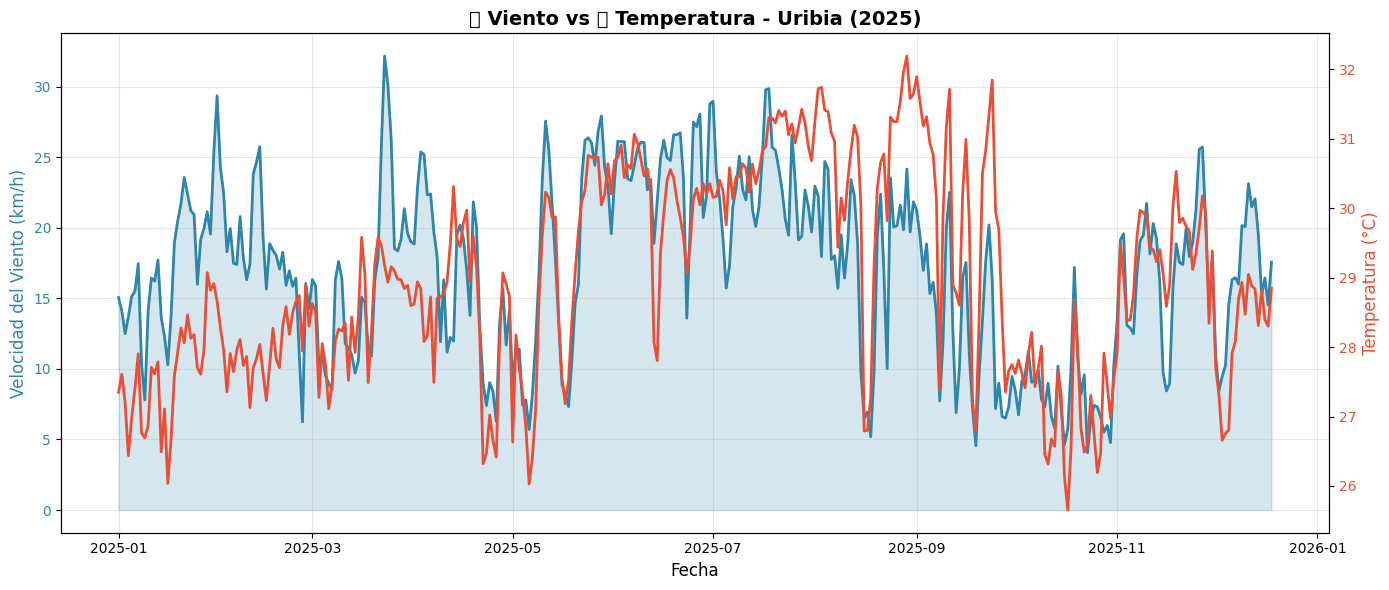

In [13]:
conn = get_connection()

query = """
    SELECT 
        CAST(datetime AS DATE) as fecha,
        AVG(wind_speed_10m) as avg_wind,
        AVG(temperature_2m) as avg_temp
    FROM climate_observations
    WHERE municipio = 'uribia'
    AND datetime >= '2025-01-01'
    GROUP BY CAST(datetime AS DATE)
    ORDER BY fecha
"""

df = pd.read_sql(query, conn)
df['fecha'] = pd.to_datetime(df['fecha'])
conn.close()

# Gráfica con doble eje Y
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje izquierdo - Viento
color1 = '#2E86AB'
ax1.plot(df['fecha'], df['avg_wind'], color=color1, linewidth=2, label='Viento')
ax1.fill_between(df['fecha'], df['avg_wind'], alpha=0.2, color=color1)
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Velocidad del Viento (km/h)', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)

# Eje derecho - Temperatura
ax2 = ax1.twinx()
color2 = '#E94F37'
ax2.plot(df['fecha'], df['avg_temp'], color=color2, linewidth=2, label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('🌬️ Viento vs 🌡️ Temperatura - Uribia (2025)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

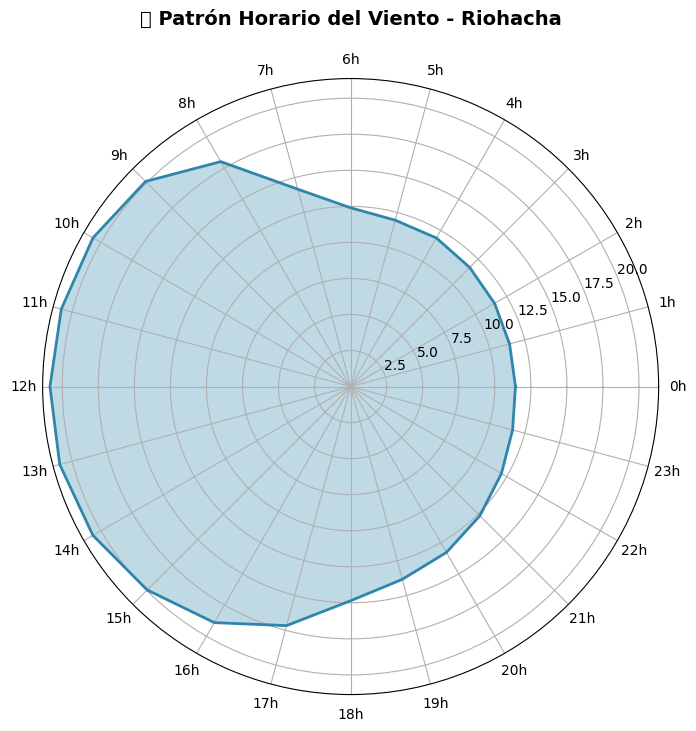

In [14]:
conn = get_connection()

query = """
    SELECT 
        DATEPART(HOUR, datetime) as hora,
        AVG(wind_speed_10m) as avg_wind
    FROM climate_observations
    WHERE municipio = 'riohacha'
    GROUP BY DATEPART(HOUR, datetime)
    ORDER BY hora
"""

df_hourly = pd.read_sql(query, conn)
conn.close()

# Gráfica polar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

theta = np.linspace(0, 2 * np.pi, 24, endpoint=False)
values = df_hourly['avg_wind'].values
theta = np.append(theta, theta[0])
values = np.append(values, values[0])

ax.plot(theta, values, color='#2E86AB', linewidth=2)
ax.fill(theta, values, alpha=0.3, color='#2E86AB')

ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
ax.set_xticklabels([f'{h}h' for h in range(24)])
ax.set_title('🕐 Patrón Horario del Viento - Riohacha', fontsize=14, fontweight='bold', pad=20)

plt.show()

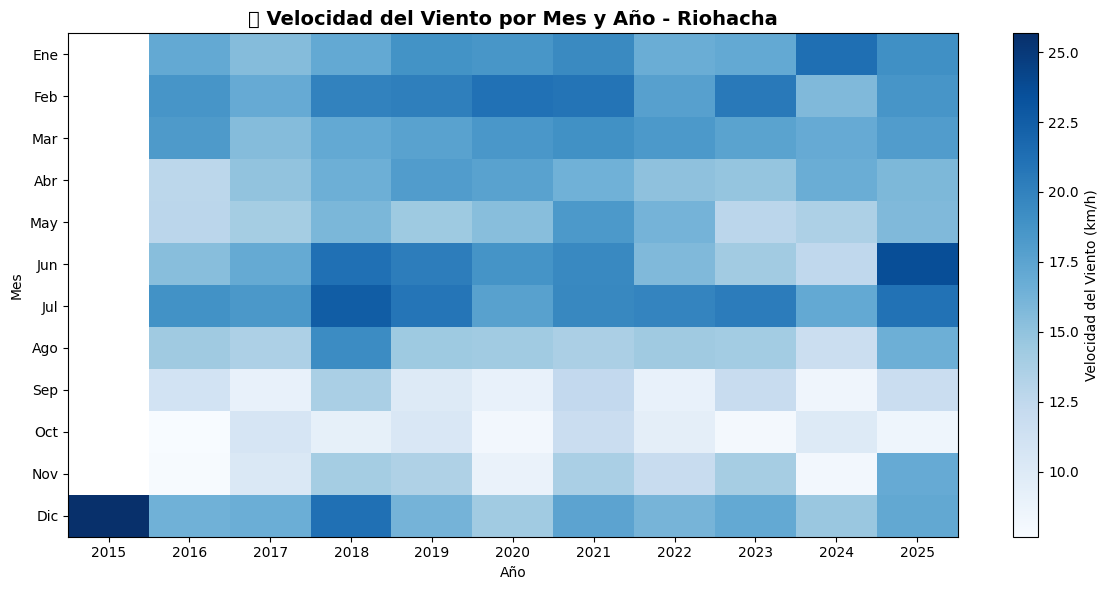

In [15]:
conn = get_connection()

query = """
    SELECT 
        YEAR(datetime) as year,
        MONTH(datetime) as month,
        AVG(wind_speed_10m) as avg_wind
    FROM climate_observations
    WHERE municipio = 'riohacha'
    GROUP BY YEAR(datetime), MONTH(datetime)
    ORDER BY year, month
"""

df = pd.read_sql(query, conn)
conn.close()

# Pivotear para heatmap
pivot = df.pivot(index='month', columns='year', values='avg_wind')

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pivot.values, cmap='Blues', aspect='auto')

ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.colorbar(im, label='Velocidad del Viento (km/h)')
ax.set_title('📅 Velocidad del Viento por Mes y Año - Riohacha', fontsize=14, fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('Mes')

plt.tight_layout()
plt.show()